## Treinando web scrapping

Nesse notebook está registrado um desafio de Análise de Dados em Python feito em equipe para processo de trainee da EJ.

Os dados foram retirados do site próprio para webscrapping, o [books to scrape](https://books.toscrape.com).

In [6]:
# Importando bibliotecas
import requests
from bs4 import BeautifulSoup

Scraping das informações:
- Título
- Descrição
- Categoria
- Preço
- Avalicação

In [7]:
books = []
for i in range(1,11):
  url = f"https://books.toscrape.com/catalogue/page-{i}.html"

  # Acessa os dados do site
  response_inicial = requests.get(url)
  response_inicial.encoding = 'utf-8' # decodificando por conta de caracteres especiais
  soup_inicial = BeautifulSoup(response_inicial.text, "html.parser")

  # Gerando os links de cada livro na página atual
  for link in soup_inicial.select('.product_pod h3 a'):
    livro_url = "https://books.toscrape.com/catalogue/" + link.get('href')

    # Acessa os dados do livro
    response_livro = requests.get(livro_url)
    response_livro.encoding = 'utf-8'
    soup_livro = BeautifulSoup(response_livro.text, "html.parser")

    # Capta os dados de interesse
    titulo = soup_livro.find('h1').text
    descricao = soup_livro.find('p', class_ = None)
    if descricao:
        descricao = descricao.text
    else:
        descricao = "Descrição indisponível"  # caso não haja descrição
    categoria = soup_livro.find('ul', class_ = "breadcrumb").find_all('li')[-2].text.strip()
    preco = soup_livro.find('p', class_ = 'price_color').text
    preco = float(preco[1:])
    avaliacao = soup_livro.find('p', class_ = 'star-rating')['class'][1]

    # Adiciona os dados como um dicionário ao vetor de livros
    books.append({
            'Título': titulo,
            'Descrição': descricao,
            'Categoria': categoria,
            'Preço': preco,
            'Avaliação': avaliacao
        })

Construção do DataFrame

In [8]:
# Importando pandas para manipulação dos dados
import pandas as pd

df = pd.DataFrame(books)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Título     200 non-null    object 
 1   Descrição  200 non-null    object 
 2   Categoria  200 non-null    object 
 3   Preço      200 non-null    float64
 4   Avaliação  200 non-null    object 
dtypes: float64(1), object(4)
memory usage: 7.9+ KB


In [10]:
df.columns

Index(['Título', 'Descrição', 'Categoria', 'Preço', 'Avaliação'], dtype='object')

In [11]:
df.head()

,Título,Descrição,Categoria,Preço,Avaliação
0,A Light in the Attic,It's hard to imagine a world without A Light i...,Poetry,51.77,Three
1,Tipping the Velvet,"""Erotic and absorbing...Written with starling ...",Historical Fiction,53.74,One
2,Soumission,"Dans une France assez proche de la nôtre, un h...",Fiction,50.10,One
3,Sharp Objects,"WICKED above her hipbone, GIRL across her hear...",Mystery,47.82,Four
4,Sapiens: A Brief History of Humankind,From a renowned historian comes a groundbreaki...,History,54.23,Five


### Data Cleaning

In [12]:
# Conferindo valores ausentes
print(df.isnull().sum())

# Conferindo se há duplicatas
if df.duplicated().any():
    n_duplicatas = df.duplicated(keep='first').sum()
    df = df.drop_duplicates()  # Remove duplicatas
    print(f"\nAs {n_duplicatas} duplicatas e foram excluídas.")
else:
    print("\nNão há duplicatas.")

# Converte a coluna da coluna 'Avaliação' para o tipo inteiro
def converter_palavras_para_numeros(df, coluna):
    palavra_para_numero = {
        'One': 1,
        'Two': 2,
        'Three': 3,
        'Four': 4,
        'Five': 5
    }
    df[coluna] = df[coluna].map(palavra_para_numero)
    return df
#Aplicando a função no df
df = converter_palavras_para_numeros(df, "Avaliação")

# Função para tratar as categorias sem sentido no df
def renomear_categorias_ausentes(df):
    df['Categoria'] = df['Categoria'].replace(['Add a comment', 'Default'], 'Uncategorized')
    return df
#Aplicando no df
df = renomear_categorias_ausentes(df)

Título       0
Descrição    0
Categoria    0
Preço        0
Avaliação    0
dtype: int64

Não há duplicatas.


In [13]:
df.shape

(200, 5)

Agora que os dados foram processados, é possível iniciar a análise.

## Quantos livros existem em cada categoria?

In [14]:
import matplotlib.pyplot as plt
import plotly.express as px

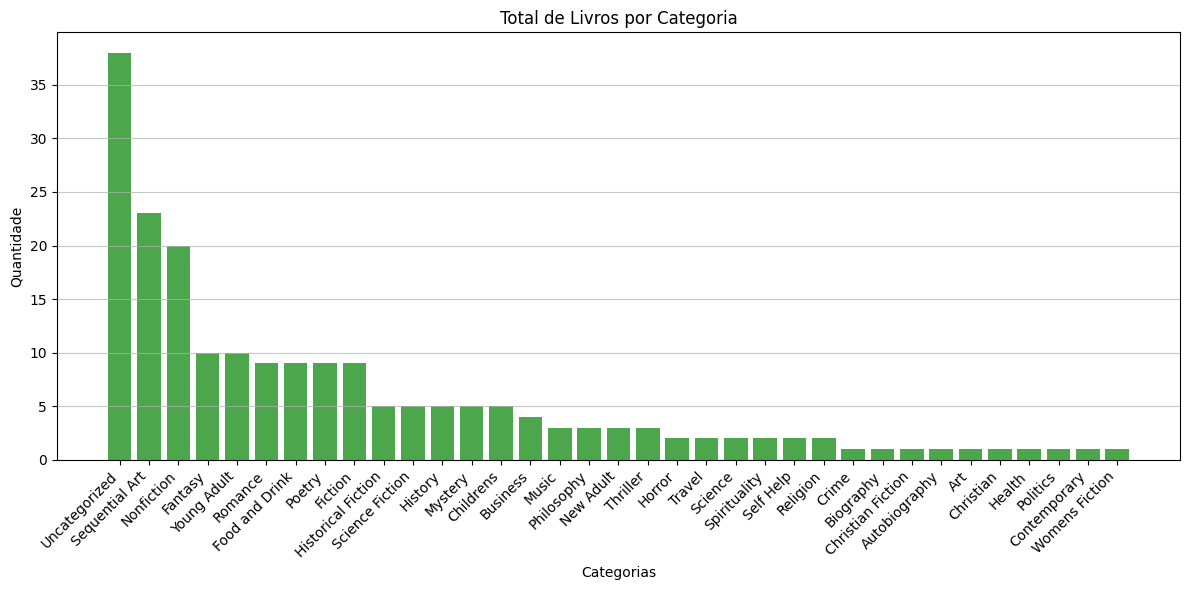

In [15]:
# Coletando e contando livros por categoria
livros_por_categoria = df['Categoria'].value_counts()

# Plotando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(livros_por_categoria.index, livros_por_categoria.values, color="green", alpha=0.7)
plt.title("Total de Livros por Categoria")
plt.xlabel("Categorias")
plt.ylabel("Quantidade")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.7)
plt.tight_layout()
plt.show()

É perceptível que existem muitos livros sem categoria definida e, também, muitos livros de categorias muito similares. Essa quantidade extensa de categorias prejudica a visualização no gráfico e atrapalha a análise.

### Solução:
Criar nova coluna 'Grupo' de categorias, para melhorar a análise geral da quantidade de livros.

In [16]:
categorias_livros = {
    "Ficção Literária": [
        "Fiction",
        "Classics",
        "Novels",
        "Short Stories",
        "Contemporary",
        "Adult Fiction",
        "Womens Fiction"
    ],
    "Ficção de Gênero e Entretenimento": [
        "Mystery",
        "Thriller",
        "Suspense",
        "Horror",
        "Romance",
        "Fantasy",
        "Science Fiction",
        "Paranormal",
        "Historical Fiction",
        "Christian Fiction",
        "Crime",
        "Erotica"
    ],
    "Literatura Infantil e Juvenil": [
        "Childrens",
        "Young Adult",
        "New Adult"
    ],
    "Biografia e Memórias": [
        "Biography",
        "Autobiography"
    ],
    "Ciências Humanas e Sociais": [
        "Philosophy",
        "Psychology",
        "History",
        "Politics",
        "Cultural",
        "Religion",
        "Christian",
        "Spirituality",
        "Academic"
    ],
    "Autoajuda e Desenvolvimento Pessoal": [
        "Self Help",
        "Health",
        "Parenting",
        "Business"
    ],
    "Arte e Expressão Criativa": [
        "Art",
        "Sequential Art",
        "Poetry",
        "Music",
        "Humor"
    ],
    "Estilo de Vida e Lazer": [
        "Travel",
        "Food and Drink",
        "Sports and Games"
    ],
    "Não-Ficção Geral": [
        "Nonfiction",
        "Science",
        "Historical",
        "Default"
    ]
}

# Função pra agrupar as categorias
def agrupa_categorias(categoria):
    for grupo, categorias in categorias_livros.items():
        if categoria in categorias:
            return grupo
    return None #Os livros como "Uncategorized" não vão aparecer

#aplicando sobre o df
df['Grupo'] = df['Categoria'].apply(agrupa_categorias)

Dessa forma, os livros sem categorias são removidos dessa análise

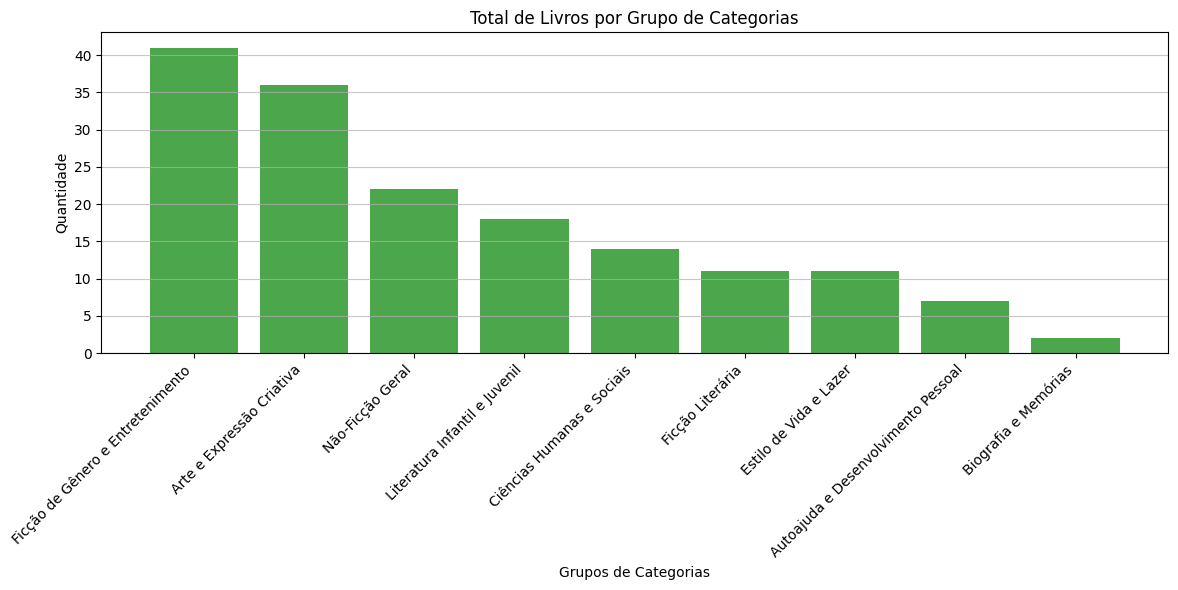

In [17]:
# contando os livros por grupo
livros_por_grupo = df['Grupo'].value_counts()

# plotando o gráfico mais conciso de grupos de categorias
plt.figure(figsize=(12, 6))
plt.bar(livros_por_grupo.index, livros_por_grupo.values, color="green", alpha=0.7)
plt.title("Total de Livros por Grupo de Categorias")
plt.xlabel("Grupos de Categorias")
plt.ylabel("Quantidade")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.7)
plt.tight_layout()
plt.show()

Analisando separadamente os livros como "Uncategorized"

In [18]:
preco_dos_nao_categorizados = df[df["Categoria"] == "Uncategorized"]
preco_dos_nao_categorizados = preco_dos_nao_categorizados['Preço'].sort_values()
preco_dos_nao_categorizados.describe().round(2)

,Preço
count,38.00
mean,32.88
std,13.21
min,10.76
25%,22.24
50%,32.64
75%,41.46
max,56.76
